

<font size = "5"> **Chapter 4: [Spectroscopy](CH4-Spectroscopy.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />



# Analysing Low-Loss Spectra with Drude Theory

[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM/main/Spectroscopy/CH4_03-Drude.ipynb)
 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MSE672-Introduction-to-TEM/blob/main/Spectroscopy/CH4_03-Drude.ipynb)


part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

by Gerd Duscher, Spring 2021

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
Materials Science & Engineering<br>
The University of Tennessee, Knoxville

Background and methods to analysis and quantification of data acquired with transmission electron microscopes.





part of 


<font size = "5"> **[Analysis of Transmission Electron Microscope Data](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)**</font>


by Gerd Duscher, 2019

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes


## Content
The main feature in a low-loss EELS spectrum is the ``volume plasmon`` peak.

The simplest theory to interprete this energy range is the Drude theory. 

Another easy to observe component is the multiple scatteringof thix plasmon peak, which we can correct for or use for thickness determination.

## Load important packages

### Check Installed Packages


In [1]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = get_distribution(package_name).version
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

# Colab setup ------------------
if 'google.colab' in sys.modules:
    !pip install pyTEMlib -q
# pyTEMlib setup ------------------
else:
    if test_package('pyTEMlib') < '0.2021.3.22':
        print('installing pyTEMlib')
        !{sys.executable} -m pip install  --upgrade pyTEMlib -q
# ------------------------------
print('done')

done


### Import all relevant libraries

Please note that the EELS_tools package from pyTEMlib is essential.

In [2]:
import sys
if 'google.colab' in sys.modules:
    %pylab --no-import-all inline
else:    
    %pylab --no-import-all notebook
    %gui qt
    
import warnings
warnings.filterwarnings('ignore')


# additional package 
import ipywidgets as ipyw
from scipy.optimize import leastsq  ## fitting routine of scipy

# Import libraries from the book
import pyTEMlib
import pyTEMlib.file_tools as ft          # File input/ output library
from pyTEMlib import eels_tools  
import pyTEMlib.KinsCat as ks         # Kinematic sCattering Library
                             # Atomic form factors from Kirklands book

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)

Populating the interactive namespace from numpy and matplotlib
Using KinsCat library version  0.5  by G.Duscher
spglib not installed; Symmetry functions of spglib disabled
pyTEM version:  0.2021.04.02


## Load and plot a spectrum
please see [Loading an EELS Spectrum](LoadEELS.ipynb) for details

Cannot overwrite file. Using:  AL_DFoffset0.00-11.hf5


<IPython.core.display.Javascript object>


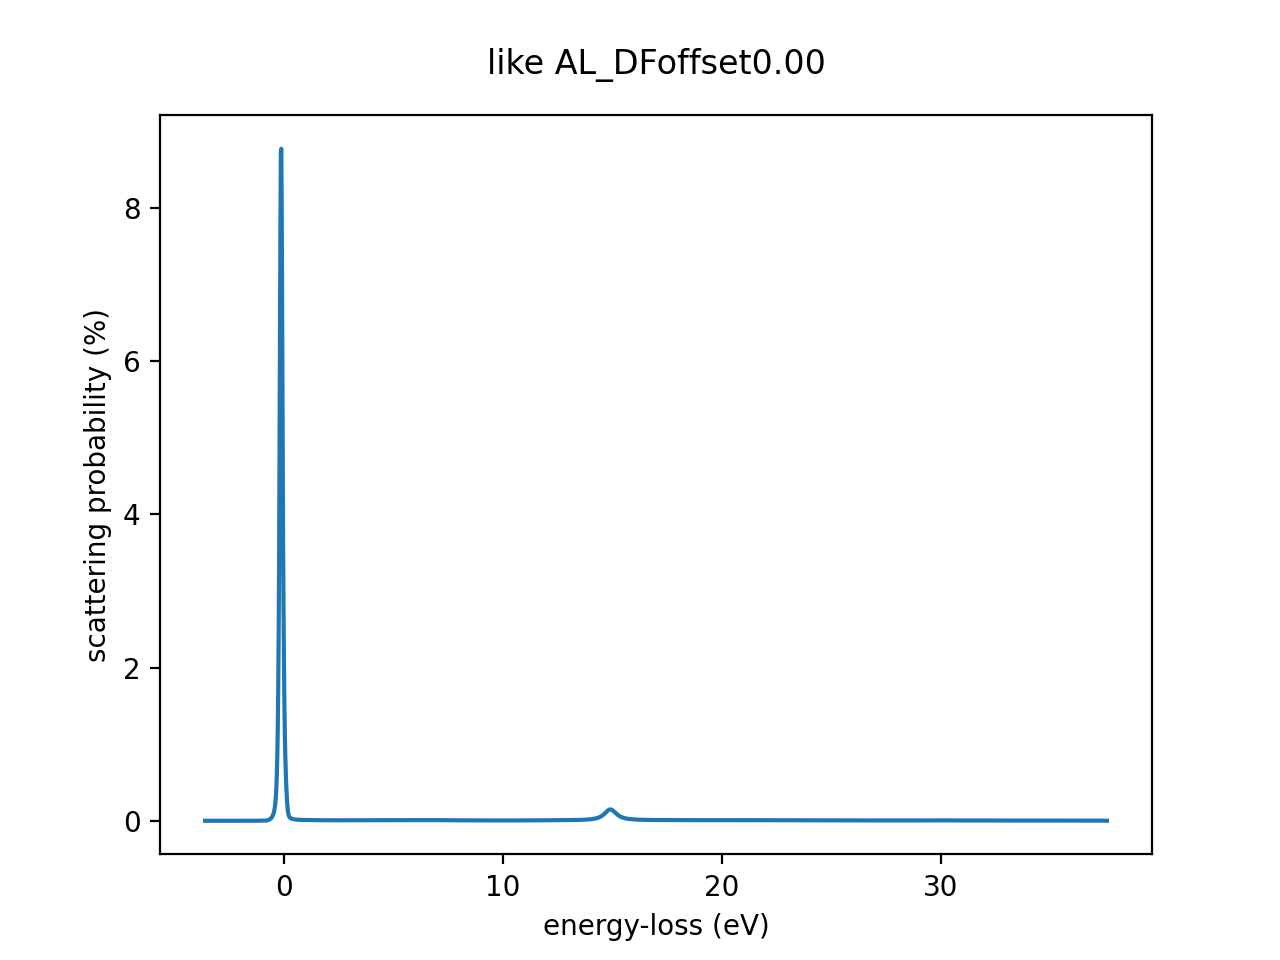

In [9]:
# Load file
filename = '../example_data/AL-DFoffset0.00.dm3'
eels_dataset = ft.open_file(filename)
if eels_dataset.data_type.name != 'SPECTRUM':
    print('We need an EELS spectrum for this notebook')

#######################################
## Important Experimental Parameters ##
#######################################
eels_dataset.metadata = eels_tools.read_dm3_eels_info(eels_dataset.original_metadata)


sum_spectrum = np.sum(np.array(eels_dataset))

eels_dataset = eels_dataset.like_data(eels_dataset/sum_spectrum*100.)
eels_dataset.units = '%'
eels_dataset.quantity = 'scattering probability'

eels_dataset.plot()

### Fix energy scale and resolution function
please see [Fitting the Zero-Loss Peak](FitZeroLoss.ipynb) for details

Zero Loss with energy resolution of 0.18 eV at position -0.134 eV
energy_loss:  energy-loss (energy_loss) of size (2048,)


<IPython.core.display.Javascript object>


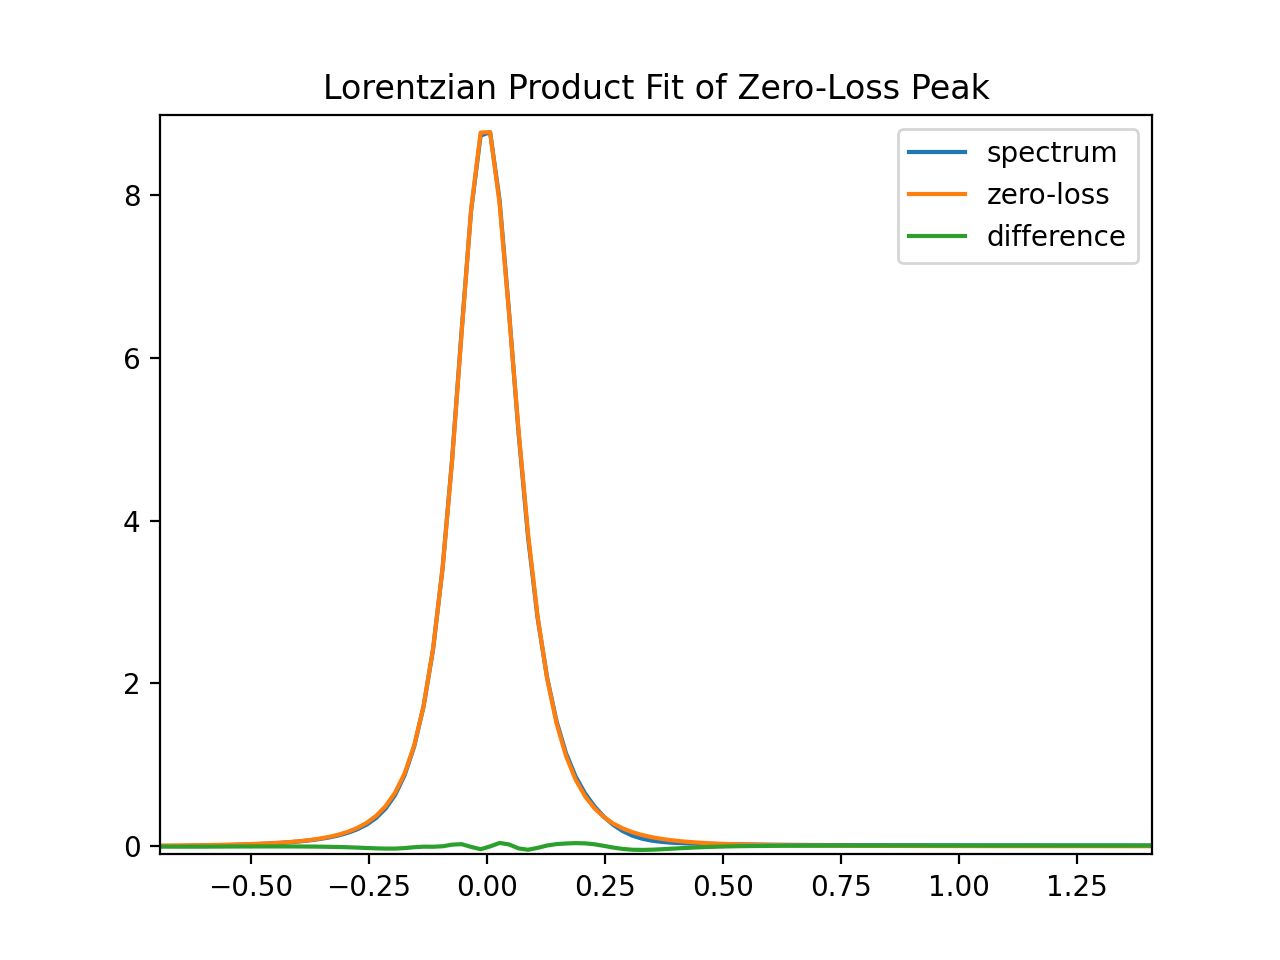

Sum of Zero-Loss: 84 counts
Sum of Spectrum: 100 counts
thickness [IMFP]: 0.17584


In [29]:
FWHM, energy_shift = eels_tools.fix_energy_scale(np.array(eels_dataset), eels_dataset.energy_loss)

print(f'Zero Loss with energy resolution of {FWHM:.2f} eV at position {Eshift:.3f} eV')
eels_dataset.energy_loss -= energy_shift

zero_loss, _ = eels_tools.resolution_function(eels_dataset.energy_loss, eels_dataset, .4)
print(zero_loss)
plt.figure()
plt.plot(eels_dataset.energy_loss, eels_dataset, label='spectrum')
plt.plot(eels_dataset.energy_loss, zero_loss, label = 'zero-loss')
plt.plot(eels_dataset.energy_loss, np.array(eels_dataset)-zero_loss , label = 'difference')

plt.title ('Lorentzian Product Fit of Zero-Loss Peak')
#plt.xlim(-5,30)
plt.legend();
Izl = zero_loss.sum()
Itotal = np.array(eels_dataset).sum()
tmfp = np.log(Itotal/Izl)
print(f'Sum of Zero-Loss: {Izl:.0f} counts')
print(f'Sum of Spectrum: {Itotal:.0f} counts')
print (f'thickness [IMFP]: {tmfp:.5f}')




## Single Scattering Deconvolution

Electrons that lost energy can interact with the sample again. The average path between two interaction is the above introduced IMFP $\lambda$. This multiple inelaxtic scattering is most obvious in the strongest energ-loss spectrum: the volume plasmon. This multiple scatering follows the Poisson statistic and the $n^{\rm th}$ scattering has the intensity:
$$I_n = I_0 P_n = (I_0/n!)(t/λ)^n \exp(−t/λ)$$

It can be shown the the single scattering spectrum in fourier space $s(v)$ can be derived by:

$$s(v) = I_0 \ln[j(v)/z(v)]$$

$z(v)$ beeing the Fourier transformed zero-loss peak (resolution function) and $j(v$ the spectrum in Fourier space.

The above formula would also correct for any instument broadening and a very noisy spectrum would result, so we need to convolute (multiplication in Fourier space) a new broadening function, which could be a well behaved Gaussian with slightly smaller energy width than the original zero-loss peak.

<IPython.core.display.Javascript object>


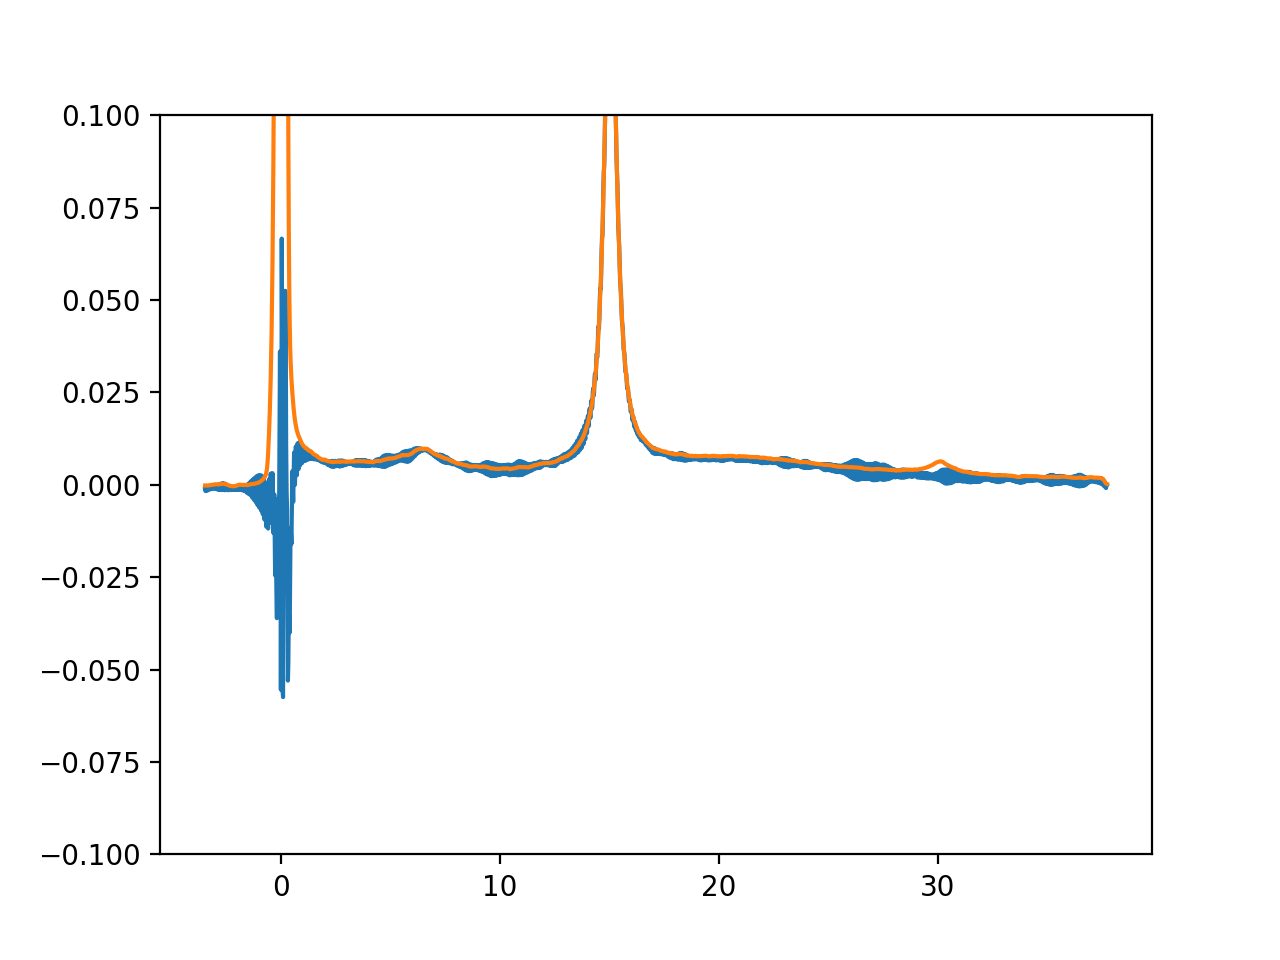

In [35]:
# Single scattering deconvolution

# Use resolution Function as ZL 

j = np.fft.fft(np.array(eels_dataset))
z = np.fft.fft(zero_loss)
z2 = z ## Could be a different zl i.e. extracted from Spectrum
j1 = z2*np.log(j/z)
ssd_low_loss =np.fft.ifft(j1).real#,'fourier-log deconvolution')

plt.figure()
#plt.plot(s.tags['ene'][start:end],  zLoss[start:end]/sumSpec*1e2)
plt.plot(eels_dataset.energy_loss,  ssd_low_loss)
plt.plot(eels_dataset.energy_loss, eels_dataset)
#plt.xlim(-4,40)
plt.ylim(-.1,.1);
eels_dataset.metadata['resolution_function'] = zero_loss

## Drude Function

The dielectric function in the Drude theory is given by two input parameters the position of the plasmon energy $E_p$
and the width of the plasmon $\Gamma$

$$ ε(ω) = ε1 + iε2 = 1 + χ = 1 − \frac{\omega_p^2}{\omega^2+\Gamma^2} + \frac{i\Gamma \omega_p^2}{\omega(\omega^2+\Gamma^2)}$$
Here $\omega$ is the angular frequency (rad/s) of forced oscillation and $\omega_p$ is the natural or resonance frequency for plasma oscillation, given by
$$ ω_p = \sqrt{\frac{ne^2}{(ε_0m_0)}} $$
A transmitted electron represents a sudden impulse of applied electric field, containing
all angular frequencies (Fourier components). Setting up a plasma oscillation of the loosely bound outer-shell electrons in a solid is equivalent to creating a pseudoparticle of energy $E_p = \hbar \omega_p$, known as a plasmon (Pines, 1963).

<IPython.core.display.Javascript object>


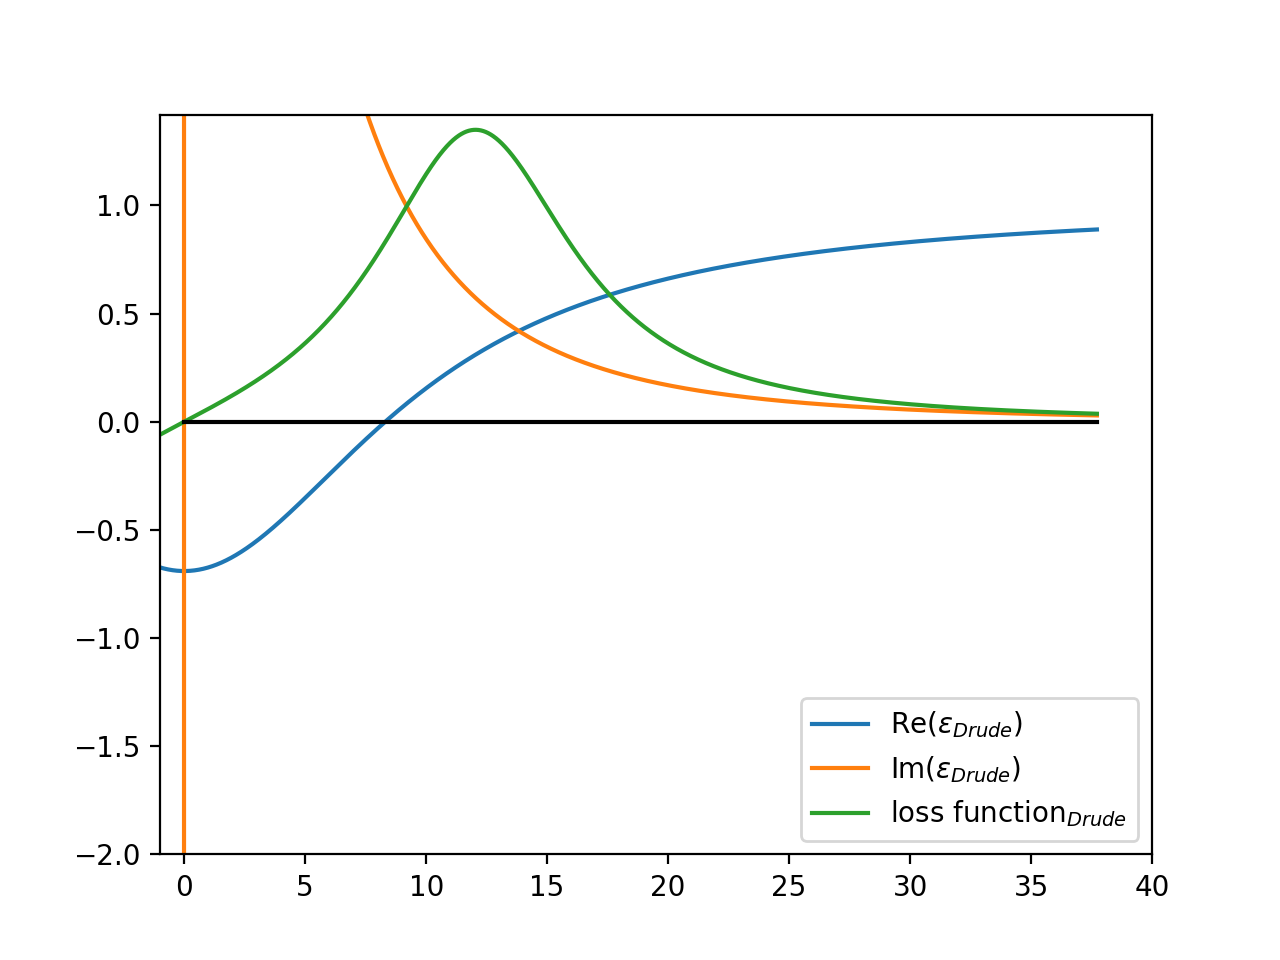

In [41]:
E_p = plasmon_energy = 13. # in eV
E_w = plasmon_gamma = 10. # in eV
energy_scale = eels_dataset.energy_loss+1e-18 #= np.linspace(0,50,1024)+1e-18

def Drude(E,E_p,E_w):
    eps = 1 - Ep**2/(E**2+E_w**2) +1j* Ew* Ep**2/E/(E**2+Ew**2)
    elf = (-1/eps).imag
    return eps,elf

eps,elf = Drude(energy_scale, plasmon_energy, plasmon_gamma)

plt.figure()
plt.plot(energy_scale, eps.real, label='Re($\epsilon_{Drude}$)')
plt.plot(energy_scale, eps.imag, label='Im($\epsilon_{Drude}$)')
plt.plot(energy_scale, elf, label='loss function$_{Drude}$')
plt.plot([0,E[-1]],[0,0],c='black')

plt.legend()
plt.gca().set_ylim(-2,max(elf)*1.05);
plt.xlim(-1,40);


## Fitting a Drude Function to Plasmon

The position and the width are important materials parameters and we can derive them by fitting the Drude function to the volume plasmon region.

<IPython.core.display.Javascript object>


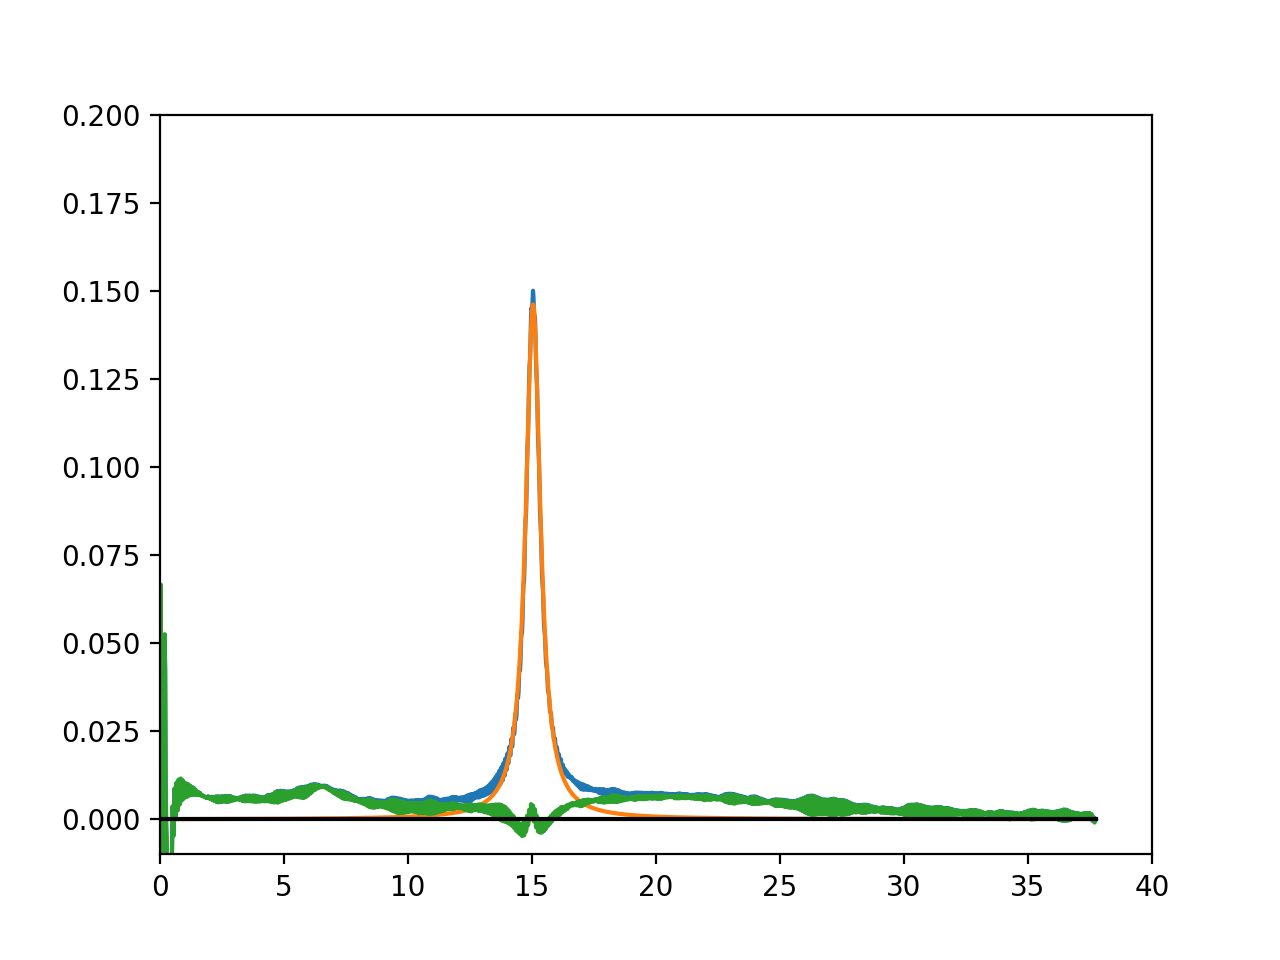

Drude Theory with Plamson Energy: 15.047837 eV and plasmon Width 0.72 eV
Max of Plasmon at 15.04 eV
Amplitude of  0.01 was deteremined by fit 


In [76]:
from scipy.optimize import leastsq

def Drude(E,Ep,Ew):
    eps = 1 - Ep**2/(E**2+Ew**2) +1j* Ew* Ep**2/E/(E**2+Ew**2)
    elf = (-1/eps).imag
    return eps,elf

def errfDrude(p, y, x):
    eps,elf = Drude(x,p[0],p[1])
    err = y - p[2]*elf
    #print (p,sum(np.abs(err)))
    return np.abs(err)#/np.sqrt(y)


pin2 = np.array([15,1,.7])

startFit =np.argmin(abs(energy_scale-13))
endFit = np.argmin(abs(energy_scale-18))
    
p2, lsq = leastsq(errfDrude, pin2, args=(ssd_low_loss[startFit:endFit], energy_scale[startFit:endFit]), maxfev=2000)

eps, elf =Drude(E,p2[0],p2[1])
drudePSD = p2[2]* elf
plt.figure()

plt.plot(E,ssdLL)
plt.plot(E,drudePSD)
plt.plot(E,ssd_low_loss-drudePSD)
plt.plot([0,E[-1]],[0,0],c='black')

plt.gca().set_xlim(0,40)
plt.gca().set_ylim(-0.01,0.2)
print(f"Drude Theory with Plamson Energy: {p2[0]:2f} eV and plasmon Width {p2[1]:.2f} eV") 
print(f"Max of Plasmon at {energy_scale[drudePSD.argmax(0)]:.2f} eV")
print(f"Amplitude of  {p2[2]:.2f} was deteremined by fit ")


<IPython.core.display.Javascript object>


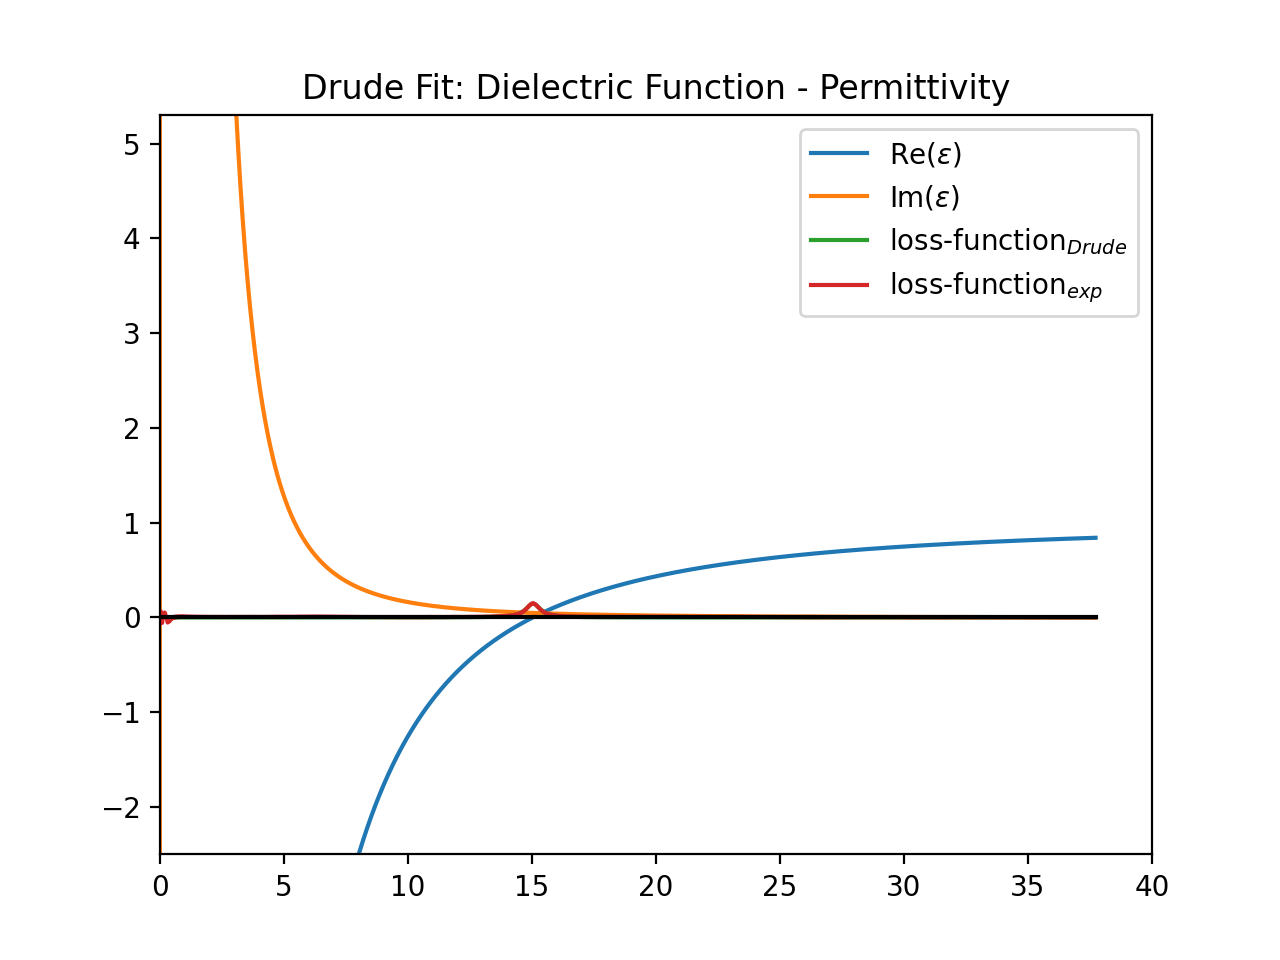

In [77]:
plt.figure()
plt.title ('Drude Fit: Dielectric Function - Permittivity')
plt.plot(E,eps.real,label = 'Re($\epsilon)$')
plt.plot(E,eps.imag,label = 'Im($\epsilon)$')
plt.plot(E,drudePSD,label = 'loss-function$_{Drude}$')
plt.plot(E,ssdLL,label = 'loss-function$_{exp}$')


plt.plot([0,E[-1]],[0,0],c='black')

plt.gca().set_xlim(0,40)
plt.gca().set_ylim(-2.5,5.3)

plt.legend();

## Navigation
- <font size = "3">  **Up Chapter 4: [Imaging](CH4_00-Spectroscopy.ipynb)** </font>
- <font size = "3">  **Back: [Overview](CH4_02-Fit_Zero_Loss.ipynb)** </font>
- <font size = "3">  **Next: [Simulation of Momentum Resolved EELS](CH4_04-Kroeger.ipynb)** </font>
- <font size = "3">  **List of Content: [Front](../_MSE672_Intro_TEM.ipynb)** </font>